In [1]:
from obscond import SkyCalculations

ModuleNotFoundError: No module named 'palpy'

In [2]:
from lsst.sims.photUtils import BandpassDict, Bandpass

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [6]:
class SkyMagCalcs(SkyCalculations):
    def __init__(self, deshwfname=None):
        self.deshwfname = deshwfname
        self._deshw = None
        super(SkyMagCalcs, self).__init__(hwBandpassDict=BandpassDict.loadBandpassesFromFiles()[1])

    @property
    def deshw(self):
        if self._deshw is not None:
            return self._deshw
        else:
            deshw = self.desHWBandpassDict(self.deshwfname)
            self._deshw = deshw
            return self._deshw

    @staticmethod
    def simlib(fname):
        df = pd.read_csv(fname, skiprows=2,
                         delim_whitespace=True,
                         names=['trash', 'ROW','LIBID','RA','DEC','MJD','BAND','ZP_pe','SKYMAG','PSF','M5SIG'],
                         index_col='ROW')
        del df['trash']
        return df

    def desHWBandpassDict(self, fname=None):
        if fname is None:
            # private bandpass currently
            fname = '/Users/rbiswas/data/DES/Kessler_DES_Cadence/STD_BANDPASSES_Y3A1_FGCM_20170320.dat-2.txt'
        desdf = pd.read_csv(fname, delim_whitespace=True)
        desdf.rename(columns={'#lambda':'wave'}, inplace=True)
        desdf.wave = desdf.wave / 10.0
        df = desdf[['g', 'r', 'i', 'z', 'Y']].divide(desdf['atm'], axis=0).join(desdf['wave'])
        bandpassNameList= ['g','r','i','z','y']
        bandpassList = list(Bandpass(df.wave.values, sb=df[bandName].values) for bandName in ['g','r','i','z','Y'])
        hwBandpassDict = BandpassDict(bandpassList, bandpassNameList)
        return hwBandpassDict
    
    def desSkyMags(self, pointings, raCol='RA', decCol='DEC', mjdCol='MJD', bandCol='BAND'):
        
        num = len(pointings)
        idxs = np.zeros(num, dtype=int)
        des_mags = np.zeros(num)
        lsst_mags = np.zeros(num)
        sm = self.sm
        
        count = 0
        for obsHistID, row in pointings.iterrows():
            ra = row[raCol]
            dec = row[decCol]
            bandName = row[bandCol]
            mjd = row[mjdCol]
            sm.setRaDecMjd(lon=ra, lat=dec,
                           filterNames=bandName, mjd=mjd,
                           degrees=False, azAlt=False)
            lsst_mags[count] = self.skymag(bandName, sm=sm,
                                           hwBandPassDict=self.adb.hwbandpassDict)
            des_mags[count] = self.skymag(bandName, sm=sm, hwBandPassDict=self.deshw)
            idxs[count] = obsHistID
            count += 1
        return pd.DataFrame(dict(obsHistID=idxs, lsst_mags=lsst_mags, des_mags=des_mags)).set_index('obsHistID')

In [7]:
smc = SkyMagCalcs(deshwfname='/Users/rbiswas/data/DES/Kessler_DES_Cadence/STD_BANDPASSES_Y3A1_FGCM_20170320.dat-2.txt')
smc.adb.hwbandpassDict

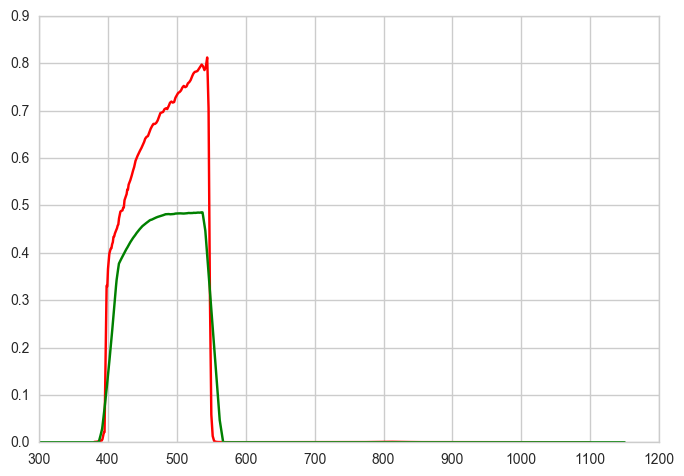

In [8]:
plt.plot(smc.deshw['g'].wavelen, smc.deshw['g'].sb, color='r')
plt.plot(smc.adb.hwbandpassDict['g'].wavelen, smc.adb.hwbandpassDict['g'].sb, color='g')

In [11]:
pointings = SkyMagCalcs.simlib('/Users/rbiswas/data/DES/Kessler_DES_Cadence/SIMLIB_DUMP_DES-griz.DAT')
pointings[['RA', 'DEC']] = pointings[['RA', 'DEC']].apply(np.radians)

In [10]:
from joblib import delayed, Parallel

In [12]:
pts = np.array_split(pointings, 40)

In [13]:
# This dataframe was calculated using the class above. Once done, we can use the saved values for making plots
#dff = smc.desSkyMags(pointings)
#dff.to_hdf('DES_pointings.hdf', key='0')
dff = pd.read_hdf('DES_pointings.hdf')

In [14]:
df = dff.join(pointings)

In [15]:
df['diff_des'] = - df.des_mags + df.SKYMAG
df['diff_lsst'] = - df.lsst_mags + df.SKYMAG

In [19]:
df.diff_des.mean()

-0.06865641764850226

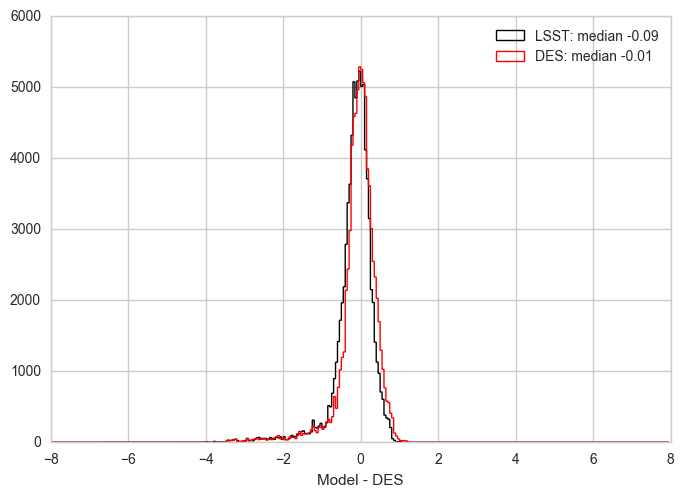

In [16]:
fig, ax  = plt.subplots()
df.diff_lsst.hist(histtype='step', bins=np.arange(-8, 8, 0.05), ax=ax, color='k', alpha=1, lw=1, label='LSST: median {0:0.2f}'.format(np.median(df.diff_lsst.dropna())))
df.diff_des.hist(histtype='step', bins=np.arange(-8, 8, 0.05), ax=ax, color='r', alpha=1, lw=1, label='DES: median {0:0.2f}'.format(np.median(df.diff_des.dropna())))
plt.legend(loc='best')
ax.set_xlabel('Model - DES')

/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/pandas/tools/plotting.py:2908: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  yrot=yrot, **kwds)


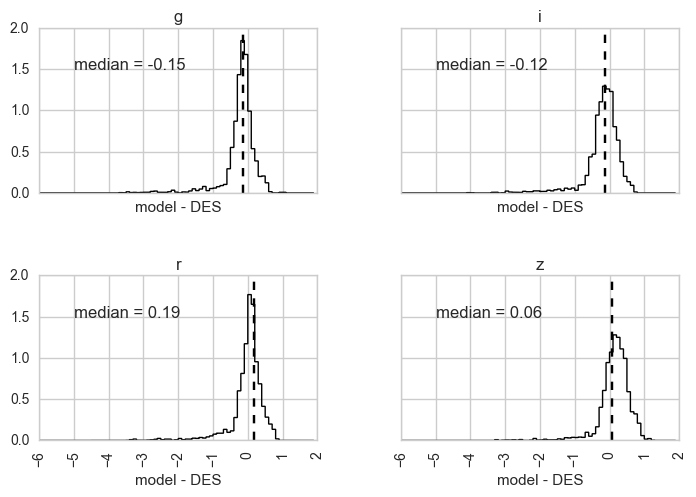

In [16]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True)
df.hist('diff_des', by='BAND', bins=np.arange(-6., 2., 0.1), histtype='step', alpha=1, color='k', normed=1, 
        cumulative=0, lw=1, sharey=True, ax=ax)
for axx, band in zip(ax.flatten(), df.BAND.unique()):
    xx = df.dropna().query('BAND == @band').diff_des
    axx.axvline(np.median(xx), ls='dashed', color='k')
    axx.text(-5, 1.5, 'median = {0:0.2f}'.format(np.median(xx)))
    axx.set_xlabel('model - DES')

So on the average, the model works quite well in each band. However, in individual measurements there are large variations including a tail which indicates that the model can be extremely bright compared to DES measurements on a handful of events. 

In [17]:
df.groupby('BAND').agg(dict(diff_des=lambda x:np.median(x), diff_lsst=lambda x:np.median(x)))

,diff_des,diff_lsst
BAND,,
g,-0.146185,-0.095597
i,-0.120146,-0.108651
r,0.063058,0.097259
z,0.191831,-0.266670


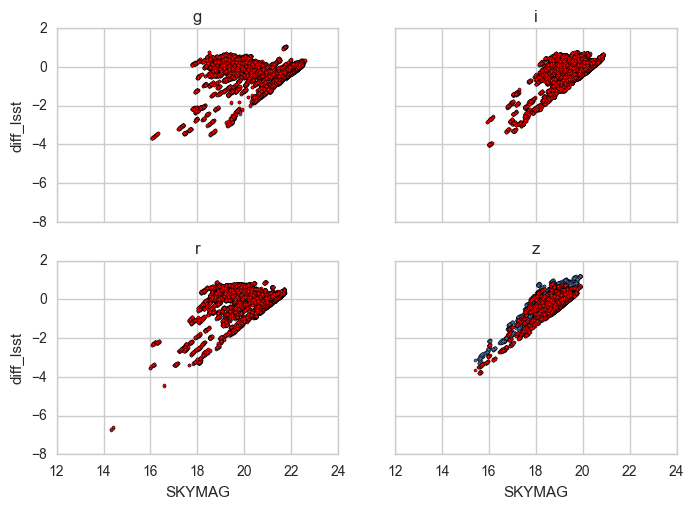

In [18]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
for (band, group), ax in zip(df.groupby('BAND'), ax.flatten()):
    group.plot(x='SKYMAG', y='diff_des', kind='scatter', ax=ax, title=band, marker='.')
    group.plot(x='SKYMAG', y='diff_lsst', kind='scatter', ax=ax, title=band, color='r', marker='.')

There is not a particular time of night where the variations are large. The two populations are very similar.

In [19]:
df['time'] = df.MJD % 1
df.time = df.time.astype(np.float) * 24.0

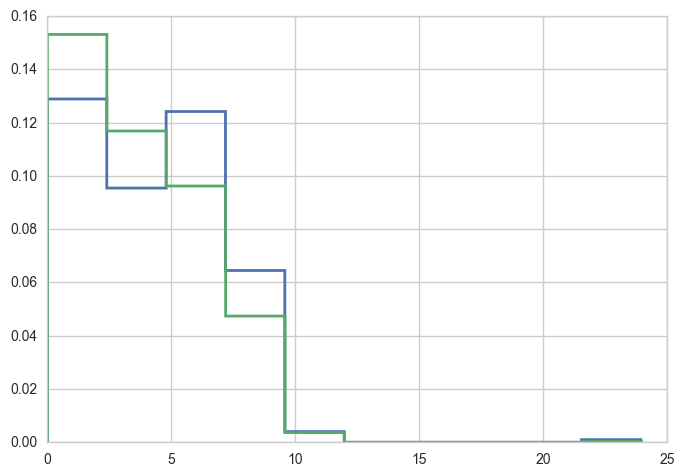

In [22]:
df.query('diff_des > 0.5 or diff_des < - 0.5').time.hist(histtype='step', lw=2, alpha=1, normed=1)
df.time.hist(histtype='step', lw=2, alpha=1, normed=1)